In [27]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


In [19]:
load_dotenv()

True

In [20]:
# web search tool 
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(max_results=2)

In [3]:
# File management tool
from langchain_community.agent_toolkits import FileManagementToolkit

working_directory = './files'

file_management_tools =FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"]
).get_tools()


read_tool, write_tool, list_tool = file_management_tools

In [4]:
write_tool.invoke({"file_path": "example.txt", "text": "Hello World!"})

'File written successfully to example.txt.'

In [5]:
# List files in the working directory
list_tool.invoke({})

'example.txt'

In [6]:
read_tool.invoke(input='example.txt')

'Hello World!'

In [8]:
#arxiv
import arxiv

@tool("arxiv_search")
def arxiv_search(query: str,max_results: int = 5) -> str:
    """
    Searches arXiv for papers matching the query.
    - query: keywords, authors or title
    - max_results: number of papers to return
    """
    try:
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )
        papers = []
        for result in search.results():
            pdf_url = result.pdf_url if hasattr(result,"pdf_url") else result.entry_id.replace("abs","pdf")
            papers.append(
                f"Title: {result.title}\n"
                f"Authors: {','.join(a.name for a in result.authors)}\n"
                f'Published: {result.published.date()}\n'
                f"Abstract: {result.summary.strip()}\n"
                f"Link: {result.entry_id}\n"
                f"PDF: {pdf_url}\n"
                + "-"*80

            )
        if not papers:
            return f"No results found for '{query}"
        return "\n".join(papers)
    except Exception as e:
        return f"Error during arXiv search: {e}"
    



In [9]:
result = arxiv_search("Quantum Machine Learning")

C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_25964\2627632007.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = arxiv_search("Quantum Machine Learning")
C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_25964\2323917343.py:18: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


In [13]:
#wikipedia
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(load_all_available_meta=True))

In [67]:
#youtube
from langchain_community.tools import YouTubeSearchTool
youtube_tool = YouTubeSearchTool()

In [21]:
# tools
tools = [arxiv_search,wikipedia_tool,youtube_tool,read_tool, write_tool, list_tool,web_search_tool]

In [23]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
llm_with_tools = llm.bind_tools(tools)


GRAPH BUILDING

In [24]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]

In [83]:
tool_name  = ",".join(tool.name for tool in tools)
tool_name

'arxiv_search,wikipedia,youtube_search,read_file,write_file,list_directory,tavily_search'

In [89]:
tool_desc  = "\n*".join(tool.description for tool in tools)
print(tool_desc)

Searches arXiv for papers matching the query.
- query: keywords, authors or title
- max_results: number of papers to return
*A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
*search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional
*Read file from disk
*Write file to disk
*List files and directories in a specified folder
*A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and c

In [112]:
system_prompt = """ 
You are a reasoning agent that uses tools to answer questions.
You must always follow the Thought → Action → Action Input → Observation loop.

"""

In [113]:
def planner_node(state):
    user_query = state['messages']

    planner_prompt = ChatPromptTemplate([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])

    planner = planner_prompt | llm_with_tools
    result = planner.invoke({'messages': state['messages']})
    print(result)

    return ({'messages':result}) 
    

In [114]:
graph = StateGraph(State)
tool_node = ToolNode(tools)
graph.add_node('planner_node',planner_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'planner_node')
graph.add_conditional_edges('planner_node',tools_condition)
graph.add_edge('tools','planner_node')
graph = graph.compile()

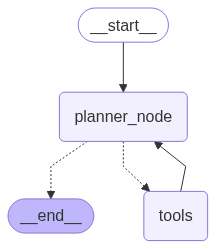

In [115]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [122]:
initial_state = {
    "messages": [HumanMessage(content="who is sachin tendulkar? show some of his best innings highlight and save those links for further use")]
}

In [123]:
result =  graph.invoke(initial_state)

content='' additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "Sachin Tendulkar"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--cac4c481-9f48-4bba-ad15-1096d888ce67-0' tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Sachin Tendulkar'}, 'id': '7aa35aa8-fe9f-4095-bb47-2586f41f8ec9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1704, 'output_tokens': 89, 'total_tokens': 1793, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 74}}
content='' additional_kwargs={'function_call': {'name': 'youtube_search', 'arguments': '{"query": "Sachin Tendulkar best innings highlights, 5"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--99dd71e9-fc71-4f2d-b3cf-f96e9ff0cc70-0' tool_ca

In [121]:
print(result['messages'][-1].content)

Sachin Ramesh Tendulkar is an Indian former international cricketer who is widely regarded as one of the greatest cricketers of all time. He holds several world records, including being the all-time highest run-scorer in both ODI and Test cricket, and is the only batsman to score 100 international centuries. He represented Mumbai domestically and India internationally for over 24 years, making his Test debut at the age of sixteen. Tendulkar was part of the Indian team that won the 2011 Cricket World Cup and was named "Player of the Tournament" at the 2003 World Cup. He has received numerous awards from the Indian government, including the Bharat Ratna, India's highest civilian award. He retired from all forms of cricket in November 2013 after playing his 200th Test match.

Here are some highlights of his best innings:
*   **Sachin Tendulkar's Masterful 162* vs New Zealand**: https://www.dailymotion.com/video/x94px9a
*   **Tendulkar has rated his match winning innings in the final match